In [1]:
import networkx as nx
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import pickle

# 1. Loading the data

## Co-location networks into NetworkX

In [56]:
nx_graphs = []
agg_graph = nx.MultiGraph()
venue_df_list = []
for i in range(31):
    # with open(f'..\ATX_Networks\sim_day_{i+1}.gexf') as graph_file:
    nx_graphs.append(nx.read_gexf(f'datasets/ATX_Networks/sim_day_{i+1}.gexf'))
    df = nx.to_pandas_edgelist(nx_graphs[i],source="Source",target="Target")
    df['day'] = i
    venue_df_list.append(df)

concat_venue_df = pd.concat(venue_df_list)
# concat_venue_df.columns = ['source','target','venueid']
concat_venue_df.head()

,Source,Target,hour,visits,venueid,id,time_spent,day
0,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,d531979041494d0d0d2387cfc611f6e70d91bcb92cf966...,2,18,440da2cbf964a52091301fe3,0,976,0
1,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,cf4e564f4c8e3aecc9dacafce90cada3eabaff58464e74...,2,2,440da2cbf964a52091301fe3,1,100,0
2,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,594a39e074fda9219102eff386f3da1944494aaa18c036...,4,2,440da2cbf964a52091301fe3,2,14,0
3,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,a1470e73f1bc4f7c757c49138afd84bd1ad09e9277526a...,5,3,440da2cbf964a52091301fe3,3,148,0
4,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,6f8848838f9afe5a7b38c23ad5018179f69e518ee721ba...,5,9,440da2cbf964a52091301fe3,4,526,0


Merge venue_id data

In [57]:
places_df = pd.read_csv("datasets/RVF_ATX_PID_HZ_Places_Lookup.tsv",delimiter='\t')
merged_df = concat_venue_df.merge(places_df, on='venueid')
merged_df.head()

,Source,Target,hour,visits,venueid,id,time_spent,day,venuename,address,...,level1cat,level2catId,level2cat,level3catId,level3cat,chainid,chainname,parentvenueid,zip,sample
0,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,d531979041494d0d0d2387cfc611f6e70d91bcb92cf966...,2,18,440da2cbf964a52091301fe3,0,976,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all
1,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,cf4e564f4c8e3aecc9dacafce90cada3eabaff58464e74...,2,2,440da2cbf964a52091301fe3,1,100,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all
2,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,594a39e074fda9219102eff386f3da1944494aaa18c036...,4,2,440da2cbf964a52091301fe3,2,14,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all
3,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,a1470e73f1bc4f7c757c49138afd84bd1ad09e9277526a...,5,3,440da2cbf964a52091301fe3,3,148,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all
4,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,6f8848838f9afe5a7b38c23ad5018179f69e518ee721ba...,5,9,440da2cbf964a52091301fe3,4,526,0,Austin Bergstrom International Airport (AUS),3600 Presidential Blvd,...,Travel & Transport,4bf58dd8d48988d1ed931735,Airports,NaN,NaN,NaN,NaN,NaN,78719,us_all


## Merge with pre-calculated loyalty scores

Reminder: loyalty_score = 
$\frac{\#totalvisitors}{\#uniquevisitors}$	

In [4]:
loyalty_scores = pickle.load(open("graph_files/loyalty_scores.pkl", "rb"))

In [5]:
loyalty_list = []
for tuple in loyalty_scores:
	venueid = tuple[0][0][0]
	score = tuple[1]
	loyalty_list.append((venueid, round(score)))

In [6]:
loyalty_scores = pd.DataFrame(loyalty_list, columns = ["venueid", "loyalty_score"])
# loyalty_scores["loyalty_score"] = pd.Categorical(loyalty_scores.loyalty_score)
# loyalty_scores.head()
# merged_df["loyalty_score"].unique()

loyalty_scores.dtypes

venueid          object
loyalty_score     int64
dtype: object

In [7]:
merged_df = pd.merge(merged_df, loyalty_scores, on = "venueid")

In [8]:
source_set = set(merged_df['Source'].unique())
target_set = set(merged_df['Target'].unique())
node_set = source_set.union(target_set)

In [9]:
size = len(node_set)
node_encodings = np.arange(size)
node_list = list(node_set)

## Load negative edges
Negative edges are required to teach the model examples of when a co-location does *not* occur.

In [10]:
neg_df = pd.read_csv("datasets/neg_samples_180000.csv")
features_df_neg = neg_df.copy()[["Source","Target","venueid","hour","time_spent","visits"]]
features_df_neg = features_df_neg.astype({"hour":"int32","visits":"int32","time_spent":"int32"})
features_df_neg = features_df_neg.merge(places_df[['level1cat','venueid']], on='venueid')
features_df_neg.head()

,Source,Target,venueid,hour,time_spent,visits,level1cat
0,4ed23ffbfe4a8997f5172d7d2da88b7b75357e4c21af6f...,d8e4658adb2cd20d208eb6f089e4c482bf7ec7fa084ea9...,4b8ab9c1f964a520a67c32e3,3,2062,25,Shops & Services
1,cf0b83f6cde68d475abb3d82ed316273ed0856e30ce1ef...,f9e5bde0ec17235ca5e921717b57bc0ede0344fe8760d3...,4b8ab9c1f964a520a67c32e3,23,3325,29,Shops & Services
2,c02f1f8e75c424098241774603eea52222d5b7d4d60c5d...,33283de883dfbbc53475b9dab3dec4a6cb35de0e8ea14d...,4b8ab9c1f964a520a67c32e3,23,189,41,Shops & Services
3,15cf3f776ad9e4dbccb533242c58b53fc61ef384f5ea5d...,113b3c657ecd221fb4cbbb5b4b02f0c1b128b33862fa29...,4b8ab9c1f964a520a67c32e3,14,2073,22,Shops & Services
4,c58106b1ca52af9eed41cf74b5f76299bc5210076f5831...,21d4302b1c13e01be5e9a10c55a7cb39b8fe0332e68c04...,4b8ab9c1f964a520a67c32e3,22,337,57,Shops & Services


# 2. Additional data preprocessing

In [11]:
features_df_pos = merged_df.copy()[["Source","Target","venueid","hour","time_spent","visits","day", "loyalty_score"]]
features_df_pos = features_df_pos.merge(places_df[['level1cat','venueid']], on='venueid')
features_df_pos.head()

,Source,Target,venueid,hour,time_spent,visits,day,loyalty_score,level1cat
0,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,d531979041494d0d0d2387cfc611f6e70d91bcb92cf966...,440da2cbf964a52091301fe3,2,976,18,0,19,Travel & Transport
1,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,cf4e564f4c8e3aecc9dacafce90cada3eabaff58464e74...,440da2cbf964a52091301fe3,2,100,2,0,19,Travel & Transport
2,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,594a39e074fda9219102eff386f3da1944494aaa18c036...,440da2cbf964a52091301fe3,4,14,2,0,19,Travel & Transport
3,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,a1470e73f1bc4f7c757c49138afd84bd1ad09e9277526a...,440da2cbf964a52091301fe3,5,148,3,0,19,Travel & Transport
4,2adee8895bc53ddebe8fb9c8a532f8bb5105a0d5bdcfd7...,6f8848838f9afe5a7b38c23ad5018179f69e518ee721ba...,440da2cbf964a52091301fe3,5,526,9,0,19,Travel & Transport


## Enforce an order for (source, target), and create a unique encoding for each node
The order is critical for ensuring the model does not treat an edge (u,v) as different from (v,u).
Source and target encoding are important for efficiently training the model, as unique IDs are too long.

In [12]:
node_encoding_df = pd.DataFrame({'Node':node_list,'Source_Encoding':node_encodings})
encoded_df = features_df_pos.merge(node_encoding_df, left_on='Source',right_on='Node', how='left')
node_encoding_df = pd.DataFrame({'Node':node_list,'Target_Encoding':node_encodings})
encoded_df = encoded_df.merge(node_encoding_df, left_on='Target',right_on='Node', how ='left')
encoded_df_pos = encoded_df.drop(['Node_x','Node_y'],axis=1)
#preserve temporal day order by sorting on day
encoded_df_pos = encoded_df_pos.sort_values(by='day').reset_index(drop=True)
#impose source<target ordering to address source-target target-source duplicates
encoded_df_pos.loc[encoded_df_pos['Source_Encoding']>encoded_df_pos['Target_Encoding'],['Source_Encoding','Target_Encoding']] = encoded_df_pos.loc[encoded_df_pos['Source_Encoding']>encoded_df_pos['Target_Encoding'],['Target_Encoding','Source_Encoding']].values


In [13]:
node_encoding_df = pd.DataFrame({'Node':node_list,'Source_Encoding':node_encodings})
encoded_df = features_df_neg.merge(node_encoding_df, left_on='Source',right_on='Node',how = 'left')
node_encoding_df = pd.DataFrame({'Node':node_list,'Target_Encoding':node_encodings})
encoded_df = encoded_df.merge(node_encoding_df, left_on='Target',right_on='Node', how = 'left')
encoded_df_neg = encoded_df.drop(['Node_x','Node_y'],axis=1)
#impose source<target ordering to address source-target target-source duplicates
encoded_df_neg.loc[encoded_df_neg['Source_Encoding']>encoded_df_neg['Target_Encoding'],['Source_Encoding','Target_Encoding']] = encoded_df_neg.loc[encoded_df_neg['Source_Encoding']>encoded_df_neg['Target_Encoding'],['Target_Encoding','Source_Encoding']].values

## One-hot encoding of venue categories
This is important from a machine learning standpoint, so as not to imply an ordinal relationship between venue categories.

In [14]:
encoded_df_pos = encoded_df_pos.drop(['Source','Target','day'],axis=1)
encoded_df_neg = encoded_df_neg.drop(['Source','Target'],axis=1)
encoded_df_pos.head()

,venueid,hour,time_spent,visits,loyalty_score,level1cat,Source_Encoding,Target_Encoding
0,440da2cbf964a52091301fe3,2,976,18,19,Travel & Transport,2253,8716
1,4b3f8ef6f964a5200ea925e3,19,30,3,2,Shops & Services,6964,19416
2,4b3f8ef6f964a5200ea925e3,19,33,3,2,Shops & Services,18139,19416
3,4b3f8ef6f964a5200ea925e3,18,12,2,2,Shops & Services,11499,15591
4,4b3f8ef6f964a5200ea925e3,18,9,3,2,Shops & Services,15591,27142


In [15]:
# merged_df['level1cat'].value_counts()
encoded_df_pos['level1cat'] = encoded_df_pos['level1cat'].astype('category')
one_hot = pd.get_dummies(encoded_df_pos.level1cat,prefix="cat")
encoded_df_pos = encoded_df_pos.join(one_hot)
encoded_df_pos.columns

Index(['venueid', 'hour', 'time_spent', 'visits', 'loyalty_score', 'level1cat',
       'Source_Encoding', 'Target_Encoding', 'cat_Arts & Entertainment',
       'cat_Colleges & Universities', 'cat_Events', 'cat_Food',
       'cat_Nightlife Spots', 'cat_Outdoors & Recreation',
       'cat_Professional & Other Places', 'cat_Residences',
       'cat_Shops & Services', 'cat_Travel & Transport'],
      dtype='object')

In [16]:
encoded_df_neg['level1cat'] = encoded_df_neg['level1cat'].astype('category')
one_hot = pd.get_dummies(encoded_df_neg.level1cat,prefix="cat")
encoded_df_neg = encoded_df_neg.join(one_hot)
encoded_df_neg = pd.merge(encoded_df_neg, loyalty_scores, on = "venueid")
encoded_df_neg.columns

Index(['venueid', 'hour', 'time_spent', 'visits', 'level1cat',
       'Source_Encoding', 'Target_Encoding', 'cat_Arts & Entertainment',
       'cat_Colleges & Universities', 'cat_Events', 'cat_Food',
       'cat_Nightlife Spots', 'cat_Outdoors & Recreation',
       'cat_Professional & Other Places', 'cat_Residences',
       'cat_Shops & Services', 'cat_Travel & Transport', 'loyalty_score'],
      dtype='object')

## Binning time values
[morning, mid-day, evening/night, and retain negative edges]

In [17]:
# df.loc[df["hour"] <=8]
encoded_df_pos["binned_time"] = pd.cut(encoded_df_pos["hour"], bins = [0, 8, 16, 25], labels = [0, 1, 2], include_lowest = True)
encoded_df_neg["binned_time"] = -1

In [18]:
encoded_df_pos["binned_time"].unique()

[0, 2, 1]
Categories (3, int64): [0 < 1 < 2]

In [19]:
encoded_df_pos[["hour", "binned_time"]].groupby("binned_time", dropna = False).head()
# encoded_df_pos[["hour", "binned_time"]].groupby("hour").count()

,hour,binned_time
0,2,0
1,19,2
2,19,2
3,18,2
4,18,2
5,17,2
27,14,1
28,14,1
29,14,1
31,16,1


In [20]:
encoded_df_pos.head()

,venueid,hour,time_spent,visits,loyalty_score,level1cat,Source_Encoding,Target_Encoding,cat_Arts & Entertainment,cat_Colleges & Universities,cat_Events,cat_Food,cat_Nightlife Spots,cat_Outdoors & Recreation,cat_Professional & Other Places,cat_Residences,cat_Shops & Services,cat_Travel & Transport,binned_time
0,440da2cbf964a52091301fe3,2,976,18,19,Travel & Transport,2253,8716,0,0,0,0,0,0,0,0,0,1,0
1,4b3f8ef6f964a5200ea925e3,19,30,3,2,Shops & Services,6964,19416,0,0,0,0,0,0,0,0,1,0,2
2,4b3f8ef6f964a5200ea925e3,19,33,3,2,Shops & Services,18139,19416,0,0,0,0,0,0,0,0,1,0,2
3,4b3f8ef6f964a5200ea925e3,18,12,2,2,Shops & Services,11499,15591,0,0,0,0,0,0,0,0,1,0,2
4,4b3f8ef6f964a5200ea925e3,18,9,3,2,Shops & Services,15591,27142,0,0,0,0,0,0,0,0,1,0,2


In [21]:
encoded_df_neg.head()

,venueid,hour,time_spent,visits,level1cat,Source_Encoding,Target_Encoding,cat_Arts & Entertainment,cat_Colleges & Universities,cat_Events,cat_Food,cat_Nightlife Spots,cat_Outdoors & Recreation,cat_Professional & Other Places,cat_Residences,cat_Shops & Services,cat_Travel & Transport,loyalty_score,binned_time
0,4b8ab9c1f964a520a67c32e3,3,2062,25,Shops & Services,20311,28119,0,0,0,0,0,0,0,0,1,0,1,-1
1,4b8ab9c1f964a520a67c32e3,23,3325,29,Shops & Services,3581,13664,0,0,0,0,0,0,0,0,1,0,1,-1
2,4b8ab9c1f964a520a67c32e3,23,189,41,Shops & Services,3744,27356,0,0,0,0,0,0,0,0,1,0,1,-1
3,4b8ab9c1f964a520a67c32e3,14,2073,22,Shops & Services,2975,6389,0,0,0,0,0,0,0,0,1,0,1,-1
4,4b8ab9c1f964a520a67c32e3,22,337,57,Shops & Services,24910,27359,0,0,0,0,0,0,0,0,1,0,1,-1


# 3. Machine Learning Preprocessing and Training

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from datetime import datetime
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier, Pool

In [33]:
def results(model, X_train, X_valid,y_train, y_valid):
    soft_probs = model.predict_proba(X_valid)
    # print(soft_probs)
    valid_auc = roc_auc_score(y_valid, soft_probs, multi_class = "ovo")
    # print(f"Training accuracy: {valid_auc}")
    train_preds = model.predict(X_train)
    acc = accuracy_score(y_train, train_preds)
    print(f"Training accuracy: {acc}")
    preds = model.predict(X_valid)
    acc = accuracy_score(y_valid, preds)
    
    print(f"Validation accuracy: {acc}")
    cf_matrix = confusion_matrix(y_valid, preds)
    print(classification_report(y_valid,preds))
    return cf_matrix

In [54]:
def plot_confusion(cf_matrix):
#     group_names = ['-1','0','1','2']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v2}\n{v3}" for v2, v3 in
            zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(4,4)
    plt.clf()
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()

## Split data into test and train, preserving temporal ordering

In [25]:
# X = encoded_df.drop(['venueid','link','level1cat','day'],axis=1)

X_train_pos = encoded_df_pos[:int(0.75*len(encoded_df_pos))]
X_valid_pos = encoded_df_pos[int(0.75*len(encoded_df_pos)):]
X_train_neg = encoded_df_neg[:int(0.75*len(encoded_df_neg))]
X_valid_neg = encoded_df_neg[int(0.75*len(encoded_df_neg)):]
X_train_total = X_train_pos.append(X_train_neg)
X_valid_total = X_valid_pos.append(X_valid_neg)

X_train_total = X_train_total.sample(frac=1).reset_index(drop=True)
X_valid_total = X_valid_total.sample(frac=1).reset_index(drop=True)

X_valid_gephi = X_valid_total.copy()

y_train_total = X_train_total['binned_time']
y_valid_total = X_valid_total['binned_time']
X_train_total = X_train_total.drop(['hour', 'venueid', 'level1cat', 'binned_time'], axis=1)
X_valid_total = X_valid_total.drop(['hour', 'venueid', 'level1cat', 'binned_time'], axis=1)

In [26]:
X_train_pos["binned_time"].unique()

[0, 2, 1]
Categories (3, int64): [0 < 1 < 2]

In [27]:
len(X_train_total.columns)

15

## Define parameters of the catboost model

In [28]:
cat_indices = range(len(X_train_total.columns))
model_cat = CatBoostClassifier(iterations = 500,
                                cat_features=cat_indices,
                                verbose=100,
                                eval_metric='AUC:hints=skip_train~false',
                                loss_function='MultiClass'
                                )

In [29]:
X_train_total.head()

,time_spent,visits,loyalty_score,Source_Encoding,Target_Encoding,cat_Arts & Entertainment,cat_Colleges & Universities,cat_Events,cat_Food,cat_Nightlife Spots,cat_Outdoors & Recreation,cat_Professional & Other Places,cat_Residences,cat_Shops & Services,cat_Travel & Transport
0,1247,6,0,292,8363,0,0,0,0,0,0,1,0,0,0
1,3173,25,1,18731,22280,0,0,0,0,0,0,0,0,1,0
2,2426,41,1,350,18754,0,0,0,0,0,0,0,0,1,0
3,15,3,2,2009,13648,0,0,0,0,0,0,0,0,1,0
4,1821,9,1,18926,28462,0,0,0,0,0,1,0,0,0,0


## Train the catboost model

In [30]:
model_cat.fit(X_train_total,y_train_total)

Learning rate set to 0.190382
0:	learn: 0.7748464	total: 530ms	remaining: 4m 24s
100:	learn: 0.9485939	total: 35s	remaining: 2m 18s
200:	learn: 0.9531945	total: 1m 8s	remaining: 1m 41s
300:	learn: 0.9559183	total: 1m 42s	remaining: 1m 7s
400:	learn: 0.9579929	total: 2m 15s	remaining: 33.4s
499:	learn: 0.9596125	total: 2m 48s	remaining: 0us


## Accuracy

In [35]:
cf_matrix = results(model_cat,X_train_total, X_valid_total, y_train_total, y_valid_total)

Training accuracy: 0.9889171152055493
Validation accuracy: 0.8132312004827627
              precision    recall  f1-score   support

          -1       0.98      1.00      0.99     45000
           0       0.42      0.17      0.24      3126
           1       0.73      0.84      0.78     39064
           2       0.50      0.35      0.41     15552

    accuracy                           0.81    102742
   macro avg       0.66      0.59      0.61    102742
weighted avg       0.80      0.81      0.80    102742



## Confusion Matrix

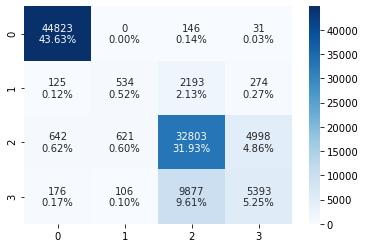

In [55]:
plot_confusion(cf_matrix)

## Feature Importance

In [ ]:
pd.DataFrame({'feature_importance': model_cat.get_feature_importance(), 
              'feature_names': X_train_total.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
2,21.225173,loyalty_score
0,20.223759,time_spent
4,17.244731,Target_Encoding
1,17.055225,visits
3,16.337005,Source_Encoding
13,3.537801,cat_Shops & Services
8,1.084059,cat_Food
14,0.977011,cat_Travel & Transport
11,0.920930,cat_Professional & Other Places
12,0.492682,cat_Residences


|Graph Type|Average Degree|Clustering Coefficient|
|---|---|---|
|Predicted|4.069|0.347|
|Observed|4.124|0.362|

# 4. Export to Gephi and Results

In [37]:
# converting to gephi
preds = model_cat.predict(X_valid_total)
X_predicted_gephi = X_valid_gephi.copy()
X_predicted_gephi['binned_time']=preds

X_predicted_gephi['Valid'] = 0

In [38]:
X_predicted_gephi.head()

,venueid,hour,time_spent,visits,loyalty_score,level1cat,Source_Encoding,Target_Encoding,cat_Arts & Entertainment,cat_Colleges & Universities,cat_Events,cat_Food,cat_Nightlife Spots,cat_Outdoors & Recreation,cat_Professional & Other Places,cat_Residences,cat_Shops & Services,cat_Travel & Transport,binned_time,Valid
0,440da2cbf964a52091301fe3,21,24,3,19,Travel & Transport,16616,19864,0,0,0,0,0,0,0,0,0,1,2,0
1,4b573f76f964a520322d28e3,13,50,2,3,Shops & Services,9031,22691,0,0,0,0,0,0,0,0,1,0,1,0
2,57863faa498e431760894479,14,2,2,4,Professional & Other Places,6559,25255,0,0,0,0,0,0,1,0,0,0,0,0
3,4ac11242f964a520ae9520e3,19,110,2,0,Outdoors & Recreation,1113,22083,0,0,0,0,0,1,0,0,0,0,1,0
4,45f2c1f7f964a520e4431fe3,14,272,5,11,Shops & Services,164,17562,0,0,0,0,0,0,0,0,1,0,1,0


In [39]:
X_valid_gephi['Valid'] = 1
X_valid_gephi.head()

,venueid,hour,time_spent,visits,loyalty_score,level1cat,Source_Encoding,Target_Encoding,cat_Arts & Entertainment,cat_Colleges & Universities,cat_Events,cat_Food,cat_Nightlife Spots,cat_Outdoors & Recreation,cat_Professional & Other Places,cat_Residences,cat_Shops & Services,cat_Travel & Transport,binned_time,Valid
0,440da2cbf964a52091301fe3,21,24,3,19,Travel & Transport,16616,19864,0,0,0,0,0,0,0,0,0,1,2,1
1,4b573f76f964a520322d28e3,13,50,2,3,Shops & Services,9031,22691,0,0,0,0,0,0,0,0,1,0,1,1
2,57863faa498e431760894479,14,2,2,4,Professional & Other Places,6559,25255,0,0,0,0,0,0,1,0,0,0,1,1
3,4ac11242f964a520ae9520e3,19,110,2,0,Outdoors & Recreation,1113,22083,0,0,0,0,0,1,0,0,0,0,2,1
4,45f2c1f7f964a520e4431fe3,14,272,5,11,Shops & Services,164,17562,0,0,0,0,0,0,0,0,1,0,1,1


In [47]:
X_time_gephi = pd.concat([X_predicted_gephi, X_valid_gephi])

In [48]:
times_graph = nx.from_pandas_edgelist(X_time_gephi,source = 'Source_Encoding',target='Target_Encoding', edge_attr=list(X_time_gephi.columns),create_using=nx.MultiGraph())

In [46]:
nx.write_gexf(times_graph, 'graph_files/time_graph.gexf')

## Feature Importance

In [ ]:
pd.DataFrame({'feature_importance': model_cat.get_feature_importance(), 
              'feature_names': X_train_total.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
2,21.225173,loyalty_score
0,20.223759,time_spent
4,17.244731,Target_Encoding
1,17.055225,visits
3,16.337005,Source_Encoding
13,3.537801,cat_Shops & Services
8,1.084059,cat_Food
14,0.977011,cat_Travel & Transport
11,0.920930,cat_Professional & Other Places
12,0.492682,cat_Residences


|Graph Type|Average Degree|Clustering Coefficient|
|---|---|---|
|Predicted|4.069|0.347|
|Observed|4.124|0.362|